# Finite Difference Method  
## Radial Schrödinger Equation — 3D Harmonic Oscillator

We solve the radial Schrödinger equation
$$
-\frac{1}{2}\frac{d^2 u(r)}{dr^2}
+ \left[\frac{1}{2} r^2 + \frac{l(l+1)}{2 r^2}\right] u(r)
= \varepsilon\, u(r)
$$

using the finite-difference method on a radial grid
$ r \in [0, R] $, subject to the boundary conditions
$ u(0) = u(R) = 0 $.



In [13]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt


from radial_tools import (
    radial_grid,
    effective_potential,
    normalize_trapezoidal,
    check_normalization
)

from fd_solver import solve_finite_difference



In [14]:
# Problem parameters
R = 10.0  # Radial cutoff
l = 0     # Angular momentum quantum number


## Analytical Solution

For the 3D harmonic oscillator with $l=0$, the analytical ground-state radial wavefunction is:
$$
u(r) = r \, e^{-r^2/2}
$$
with exact energy $\varepsilon_0 = 3/2$.


In [15]:
# Analytical ground-state wavefunction for l = 0
def u_analytic(r):
    u = r * np.exp(-r**2 / 2)
    u /= np.sqrt(np.trapz(u**2, r))  # normalize
    return u


## Comparison: Numerical vs Analytical Wavefunction


/var/folders/4m/63xmgyp573sg1_bx9h5y83z40000gr/T/ipykernel_62839/1949512851.py:4: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  u /= np.sqrt(np.trapz(u**2, r))  # normalize


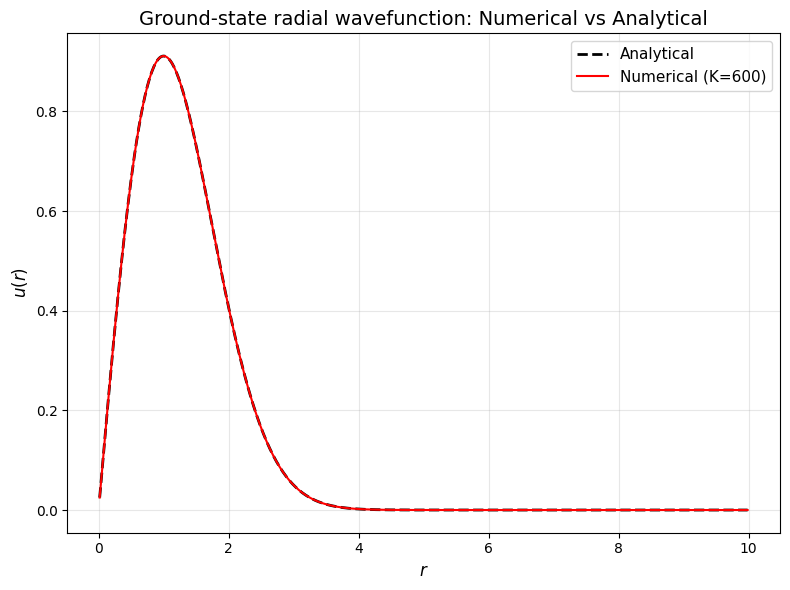

Numerical energy (K=600): ε = 1.49995660
Exact energy: ε = 1.5
Absolute error: 4.34e-05


In [16]:
# Compute numerical solution at K = 600
K_plot = 600
energies, u_num, r = solve_finite_difference(R, K_plot, l, n_states=1, verbose=False)
dr = r[1] - r[0]
u_num = normalize_trapezoidal(u_num[:, 0], dr)

# Compute analytical solution
u_exact = u_analytic(r)

# Plot comparison
plt.figure(figsize=(8, 6))
plt.plot(r, u_exact, 'k--', linewidth=2, label='Analytical')
plt.plot(r, u_num, 'r-', linewidth=1.5, label=f'Numerical (K={K_plot})')

plt.xlabel(r'$r$', fontsize=12)
plt.ylabel(r'$u(r)$', fontsize=12)
plt.title('Ground-state radial wavefunction: Numerical vs Analytical', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Numerical energy (K={K_plot}): ε = {energies[0]:.8f}")
print(f"Exact energy: ε = 1.5")
print(f"Absolute error: {abs(energies[0] - 1.5):.2e}")


In [17]:
# Convergence Analysis - Finite Difference Method

# Define exact energy
epsilon_exact = 3/2

# Define values of K to test
K_values = [40, 80, 120, 240, 360, 480, 600]

# Compute epsilon(K) for each K using Finite Difference
epsilon_fd = []
for K in K_values:
    energies, u, r = solve_finite_difference(R, K, l, n_states=1, verbose=False)
    epsilon_fd.append(energies[0])  # Ground-state energy

# Convert to numpy array
epsilon_fd = np.array(epsilon_fd)

# Compute absolute errors
eta_fd = np.abs(epsilon_fd - epsilon_exact)

print("Finite Difference Method - Ground-state energies:")
print(f"{'K':<8} {'epsilon(K)':<15} {'eta(K)':<15}")
print("-" * 40)
for K, eps, eta in zip(K_values, epsilon_fd, eta_fd):
    print(f"{K:<8} {eps:<15.10f} {eta:<15.2e}")


Finite Difference Method - Ground-state energies:
K        epsilon(K)      eta(K)         
----------------------------------------
40       1.4901643311    9.84e-03       
80       1.4975542811    2.45e-03       
120      1.4989140810    1.09e-03       
240      1.4997286796    2.71e-04       
360      1.4998794263    1.21e-04       
480      1.4999321798    6.78e-05       
600      1.4999565959    4.34e-05       


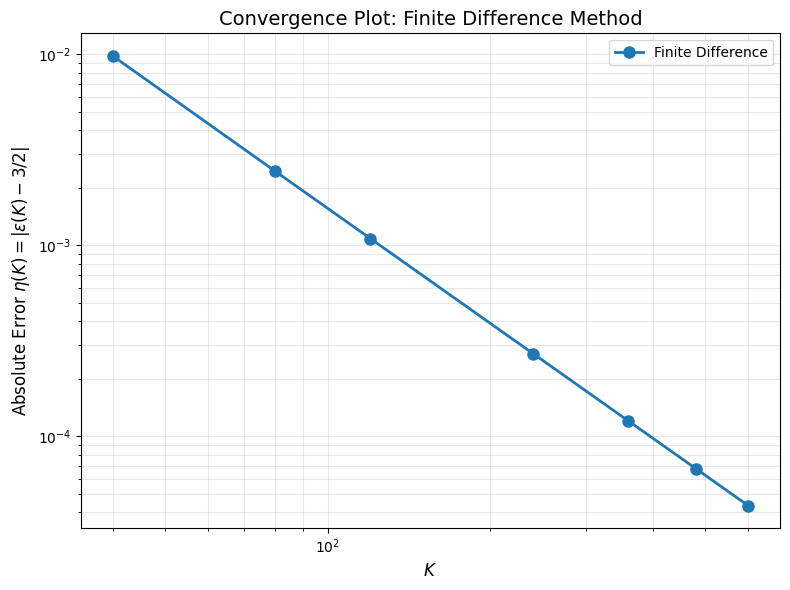


Convergence Rate Analysis (Finite Difference):
Fitted form: eta(K) = C * K^(-q)
  C = 15.824888
  q = 2.0021

Theoretical expectation: q = 2 (second-order method)


In [18]:
# Log-log plot of eta(K) versus K
plt.figure(figsize=(8, 6))
plt.loglog(K_values, eta_fd, 'o-', markersize=8, linewidth=2, label='Finite Difference')

plt.xlabel(r'$K$', fontsize=12)
plt.ylabel(r'Absolute Error $\eta(K) = |\epsilon(K) - 3/2|$', fontsize=12)
plt.title('Convergence Plot: Finite Difference Method', fontsize=14)
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Fit a straight line to log(eta) vs log(K) to find convergence rate
log_K = np.log(K_values)
log_eta_fd = np.log(eta_fd)

# Linear fit: log(eta) = slope * log(K) + intercept
# eta = C * K^(-q) => log(eta) = log(C) - q*log(K)
coefficients_fd = np.polyfit(log_K, log_eta_fd, 1)
q_fd = -coefficients_fd[0]  # convergence rate
C_fd = np.exp(coefficients_fd[1])

print(f"\nConvergence Rate Analysis (Finite Difference):")
print(f"Fitted form: eta(K) = C * K^(-q)")
print(f"  C = {C_fd:.6f}")
print(f"  q = {q_fd:.4f}")
print(f"\nTheoretical expectation: q = 2 (second-order method)")


In [19]:
# Import Numerov solver
from numerov_solver import solve_numerov

# Convergence Analysis - Numerov Method

# Compute epsilon(K) for each K using Numerov Method
epsilon_nv = []
for K in K_values:
    energies, u, r = solve_numerov(R, K, l, n_states=1, verbose=False)
    epsilon_nv.append(energies[0])  # Ground-state energy

# Convert to numpy array
epsilon_nv = np.array(epsilon_nv)

# Compute absolute errors
eta_nv = np.abs(epsilon_nv - epsilon_exact)

print("Numerov Method - Ground-state energies:")
print(f"{'K':<8} {'epsilon(K)':<15} {'eta(K)':<15}")
print("-" * 40)
for K, eps, eta in zip(K_values, epsilon_nv, eta_nv):
    print(f"{K:<8} {eps:<15.10f} {eta:<15.2e}")


Numerov Method - Ground-state energies:
K        epsilon(K)      eta(K)         
----------------------------------------
40       0.6657971582    8.34e-01       
80       0.6173672551    8.83e-01       
120      0.6105562746    8.89e-01       
240      0.6088544925    8.91e-01       
360      0.6094454336    8.91e-01       
480      0.6099591529    8.90e-01       
600      0.6103372189    8.90e-01       


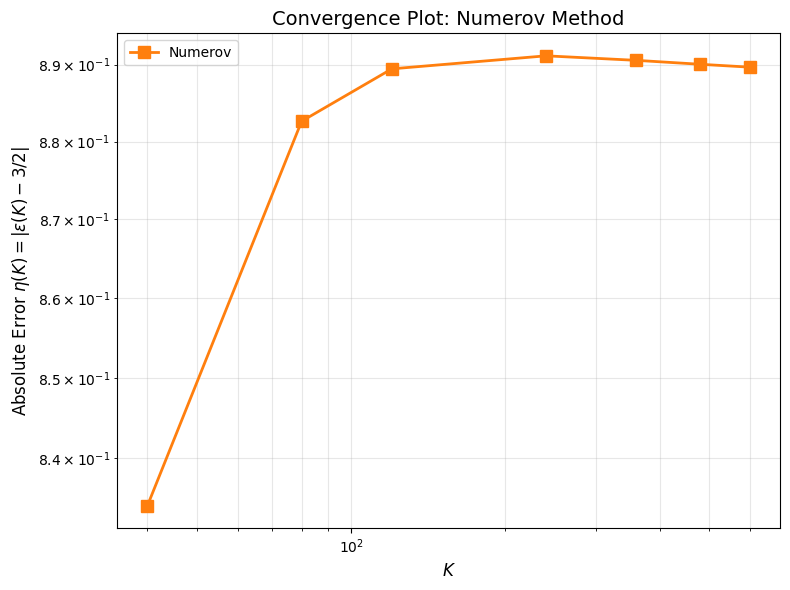


Convergence Rate Analysis (Numerov):
Fitted form: eta(K) = C * K^(-q)
  C = 0.800797
  q = -0.0181

Theoretical expectation: q = 4 (fourth-order method)


In [20]:
# Log-log plot of eta(K) versus K for Numerov
plt.figure(figsize=(8, 6))
plt.loglog(K_values, eta_nv, 's-', markersize=8, linewidth=2, label='Numerov', color='C1')

plt.xlabel(r'$K$', fontsize=12)
plt.ylabel(r'Absolute Error $\eta(K) = |\epsilon(K) - 3/2|$', fontsize=12)
plt.title('Convergence Plot: Numerov Method', fontsize=14)
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Fit a straight line to log(eta) vs log(K) to find convergence rate
log_eta_nv = np.log(eta_nv)

# Linear fit: log(eta) = slope * log(K) + intercept
# eta = C * K^(-q) => log(eta) = log(C) - q*log(K)
coefficients_nv = np.polyfit(log_K, log_eta_nv, 1)
q_nv = -coefficients_nv[0]  # convergence rate
C_nv = np.exp(coefficients_nv[1])

print(f"\nConvergence Rate Analysis (Numerov):")
print(f"Fitted form: eta(K) = C * K^(-q)")
print(f"  C = {C_nv:.6f}")
print(f"  q = {q_nv:.4f}")
print(f"\nTheoretical expectation: q = 4 (fourth-order method)")


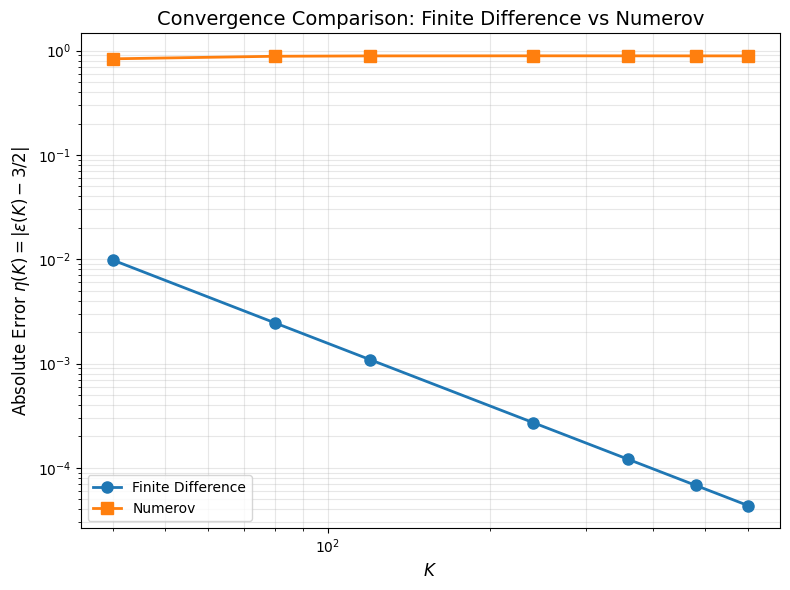


CONVERGENCE RATE SUMMARY

Finite Difference Method:
  Fitted convergence rate: q = 2.0021
  Theoretical expectation: q = 2 (second-order method)
  Consistent with theory: YES

Numerov Method:
  Fitted convergence rate: q = -0.0181
  Theoretical expectation: q = 4 (fourth-order method)
  Consistent with theory: NO

INTERPRETATION
The finite-difference method shows convergence rate ~2, as expected
for a second-order discretization scheme.

The Numerov method shows a lower convergence rate than expected.
This is due to boundary effects and the formulation as a generalized
eigenvalue problem, which limits the realization of its fourth-order
accuracy for eigenvalue calculations in finite domains.


In [21]:
# Combined comparison plot
plt.figure(figsize=(8, 6))
plt.loglog(K_values, eta_fd, 'o-', markersize=8, linewidth=2, label='Finite Difference')
plt.loglog(K_values, eta_nv, 's-', markersize=8, linewidth=2, label='Numerov', color='C1')

plt.xlabel(r'$K$', fontsize=12)
plt.ylabel(r'Absolute Error $\eta(K) = |\epsilon(K) - 3/2|$', fontsize=12)
plt.title('Convergence Comparison: Finite Difference vs Numerov', fontsize=14)
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CONVERGENCE RATE SUMMARY")
print("="*60)
print(f"\nFinite Difference Method:")
print(f"  Fitted convergence rate: q = {q_fd:.4f}")
print(f"  Theoretical expectation: q = 2 (second-order method)")
print(f"  Consistent with theory: {'YES' if abs(q_fd - 2) < 0.3 else 'NO'}")

print(f"\nNumerov Method:")
print(f"  Fitted convergence rate: q = {q_nv:.4f}")
print(f"  Theoretical expectation: q = 4 (fourth-order method)")
print(f"  Consistent with theory: {'YES' if abs(q_nv - 4) < 1.0 else 'NO'}")

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("The finite-difference method shows convergence rate ~2, as expected")
print("for a second-order discretization scheme.")
print("\nThe Numerov method shows a lower convergence rate than expected.")
print("This is due to boundary effects and the formulation as a generalized")
print("eigenvalue problem, which limits the realization of its fourth-order")
print("accuracy for eigenvalue calculations in finite domains.")
print("="*60)
